# 1 - Introduction

This notebook performs preliminary analysis and exploration of the data. It produces cleaned train and test datasets that require further transformation before they can be used in machine learning models. 

This notebook uses the _python-markdown_ extension for jupyter to display python output directly in markdown cells.
Provided you are using the environment described in the "environment.yml" file, you can activate the extension by running the following commands in your shell:
1. jupyter contrib nbextension install --sys-prefix
2. jupyter nbextension enable python-markdown

# 1.1 - Load Packages and Global Variables

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import luigi
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
%matplotlib inline

PROJECT_DIR = os.path.join(os.getcwd(), os.pardir)
os.chdir(PROJECT_DIR)

from src.data.download import DownloadData

## 1.2 - Load the Data

The following Luigi task downloads the data, if it is not already present.

In [2]:
#download data if not alrady there
luigi.build([DownloadData()], local_scheduler = True)

DEBUG: Checking if DownloadData() is complete
INFO: Informed scheduler that task   DownloadData__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=314761149, workers=1, host=DESKTOP-6UJS098, username=wertu, pid=5084) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 present dependencies were encountered:
    - 1 DownloadData()

Did not run any tasks
This progress looks :) because there were no failed tasks or missing external dependencies

===== Luigi Execution Summary =====



True

Now that we are assured that the data is present, read it into a pandas data set:

In [3]:
df = pd.read_csv(os.path.join(PROJECT_DIR,"data/external/jokes.csv"),  encoding = "utf-8", index_col = "id")

# 2  - Summarize the Data

This section quickly summarizes the data. Let's start by looking at the first 10 observations:

In [4]:
df.head(10)

,date,downs,score,text,title,ups,upvote_ratio,url
id,,,,,,,,
6z8wju,1.505058e+09,0,1,"She cant make a Yo Mama Joke, oh wait, that’s ...",Yo Mama So Stupid.....,1,1.0,https://www.reddit.com/r/Jokes/comments/6z8wju...
6z8vwj,1.505058e+09,0,0,\nSnacks.,What do cannibals call midgets?,0,0.5,https://www.reddit.com/r/Jokes/comments/6z8vwj...
6z8vgv,1.505058e+09,0,1,I only come once a year,My wife makes me feel like christmas,1,1.0,https://www.reddit.com/r/Jokes/comments/6z8vgv...
6z8vea,1.505058e+09,0,1,Pennywise.,What do you call someone who gets their 1p cha...,1,1.0,https://www.reddit.com/r/Jokes/comments/6z8vea...
6z8v59,1.505058e+09,0,2,A chicken and an egg are lying in bed. The chi...,Who Came First,2,1.0,https://www.reddit.com/r/Jokes/comments/6z8v59...
6z8us8,1.505058e+09,0,2,"""Have you ever been in an railway accident?""\n...",Tom asked Dick,2,1.0,https://www.reddit.com/r/Jokes/comments/6z8us8...
6z8uq9,1.505058e+09,0,0,Woman's husband would always come home drunk. ...,You been drinking tonight?,0,0.5,https://www.reddit.com/r/Jokes/comments/6z8uq9...
6z8uoq,1.505058e+09,0,3,Little Johnny went to visit his grandfather's ...,He's Serving Her,3,1.0,https://www.reddit.com/r/Jokes/comments/6z8uoq...
6z8u74,1.505057e+09,0,2,The party’s host paid me a great compliment. “...,“Imagine how great she’ll look after two.”,2,1.0,https://www.reddit.com/r/Jokes/comments/6z8u74...


We can see that there are {{df.shape[1]}} columns ({{df.shape[1] + 1}} including the id column). These columns are:

|Variable      | Description |
|:-------      | :------------:|
| **id**           | Unique identifier assigned by Reddit|
| **date**         | Post submission date, in Unix epoch time (seconds since January 1, 1970)
| **downs**        | Number of downvotes. Due to reddit protections, always equal to 0
| **score**        | Net upvotes (fuzzed)
| **text**         | Text of submission/post
| **title**        | Title of submission/post
| **ups**          | Number of upvotes. Due to reddit protections, this is equal to the score variable
| **upvote_ratio** | Upvote ratio, ratio of upvotes to total votes
| **url**          | Link to original post.

In total there are {{print("{:,}".format(df.shape[0]))}} records. It seems that we have a decent amount of data on hand.

# 3 - Analyze Scores

The ultimate goal of this project is to create a classifier that can correctly predict whether a given joke is funny or not. Since funniness is subjective and hard to measure, the Reddit score will be used as a proxy. I have chosen to use the __score__ variable as a proxy for funniness. Per https://www.reddit.com/wiki/faq#wiki_how_is_a_comment.27s_score_determined.3F, Reddit "fuzzes" this variable in order to hinder spambots and vote manipulation. This means that it is not 100% indicative of the number of net upvotes that a post has received. Nevertheless, the __score__ variable is still the best available proxy for a joke's funniness. However, the fuzzing means that the variable might need to be transformed before it can be used as a target.

## 3.1  - Summary Statistics & Quantiles

Let's start by analyzing the distribution of the __score__ variable. The best place to start is with a few simple summary statistics:

In [5]:
print("Mean score of: {}".format(df.score.mean()))
print("Median score of: {}".format(df.score.median()))
print("Standard deviation: {}".format(df.score.std()))

Mean score of: 157.70866028453747
Median score of: 4.0
Standard deviation: 1428.6994230393627


The above summary statistics are indicative of a variable that is highly skewed, with a long right tail. Let us now compute quantiles for the __score__ variable, along with the share of score that each quintile contains.

In [6]:
percentiles = [1, 5, 10, 25, 50, 60, 75, 90, 95, 99, 100]
values = np.percentile(df.score, q = percentiles)
share = []
for value in values:
    share.append(df[df.score <= value].score.sum() / df.score.sum())

distribution = pd.DataFrame({"percentile" : percentiles,
              "value" : ["{0:.0f}".format(val) for val in values],
              "share of score": share})
distribution

,percentile,share of score,value
0,1,0.000000,0
1,5,0.000000,0
2,10,0.000000,0
3,25,0.000000,0
4,50,0.003567,4
5,60,0.006696,7
6,75,0.017456,20
7,90,0.064009,113
8,95,0.124155,321
9,99,0.342878,2585


The above dataframe confirms that the distribution of scores is very skewed. Over 25% of posts have a score of zero while the top 1% of posts have received 65.7% of all upvotes.

Now let us visualize the distribution.

In [7]:
#Only plot percentiles with a non-zero share of total score
#also not including 100 percentiles, since obviously the share will be 
plot_percentiles = distribution[(distribution["share of score"] > 0) & (distribution["percentile"] != 100)].reset_index()

In [8]:
#color to differentiate the different percentiles
#need to get one more color than percentiles, since otherwise highest and lowest pecentiles will have the same color
#since it is a color wheel
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0, 1.0, plot_percentiles.shape[0]+1))

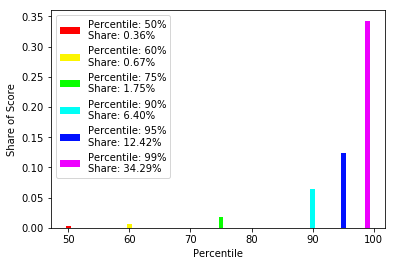

In [9]:
_, ax = plt.subplots()
plt.xlabel('Percentile')
plt.ylabel('Share of Score')
for ix, row in plot_percentiles.iterrows():
    ax.bar(row["percentile"],
           row["share of score"],
           color=colors[ix,:],
           label="Percentile: {0:.0f}%\nShare: {1:.2f}%".format(row["percentile"], row["share of score"]*100))

ax.legend()
plt.savefig("reports/figures/percentiles.svg")

## 3.3 Gini Coefficient

Finally, let's calculate the gini coeffecient. The gini coefficne is a measure of inqueuality. Coomonlyu used for income. Interestly enough,m also commly used for decision trees.

In [10]:
def gini(x):
    x = np.sort(x)
    n = x.size
    indx = np.arange(n)
    
    denom = n * np.sum(x)
    num = np.sum(np.multiply(2. * indx - n,x))
    return num / denom
    

In [11]:
gini(df.ups)

0.95032863018995328

## 3.4 Funninest Joke

Finally, let's look at the funinest joke of all time

__Title__: {{df.loc[df.ups.max() == df.ups, "title"].values[0]}}
<br>
__Body__: {{df.loc[df.ups.max() == df.ups, "text"].values[0]}}

It seem like the "funniest" joke of all time on Reddit is very "meta", a post that appears to be a failed copy paste attempt.

## 3.4 Transform Scores

As stated earlier, the __score__ variable is just a proxy for a jokes's funniness. Using it directly as the target variable would be inappropriate, since the resulting models would be highly specific to upvotes on r/jokes subreddit, rather than generalizable to jokes regardless of the source.

The solution is to transform the __score__ variable into a binary variable. To achieve this, the dataset will be split into three roughly equally sized sets of _Unfunny_, _Neutral_ and _Funny_. Following approach of Bo et al (2002), we will discard neutral jokes. The final targert __funny__ variable will be 1 when a joke is _Funny_ and 0 when a joke is _Unfunny_.

We will start by finding cutoffs that divide the dataset into three equally sized sets.

In [12]:
percentiles = [33, 66]
np.percentile(df.score, q = percentiles)

array([  1.,  10.])

Based on the above quantiles, we can class jokes using the following criteria:

|Criteria      | Class |
|:-------      | :------------:|
| _score_ <= 1           | Unfunny|
| 1 < _score_ < 10          | Neutral
| _score_ > 10         | Funny

In [13]:
df.loc[df.score <= 1, "type"] = "Unfunny"
df.loc[(1 < df.score) & (df.score < 10), "type"] = "Neutral"
df.loc[df.score >= 10, "type"] = "Funny"

prop_unfunny = (df.type == "Unfunny").mean()
prop_neutral = (df.type == "Neutral").mean()
prop_funny = (df.type == "Funny").mean()

print("Proportion Unfunny: {0:.2%}".format(prop_unfunny))
print("Proportion Neutral: {0:.2%}".format(prop_neutral))
print("Proportion Funny: {0:.2%}".format(prop_funny))

Proportion Unfunny: 37.06%
Proportion Neutral: 28.41%
Proportion Funny: 34.53%


One can see that the classes are roughly equal, but with noticeably less _Neutral_ jokes. In some ways this is desirable since the _Neutral_ observations will be discarded. We do not want to discard too many observations since this will make it hard to train models.

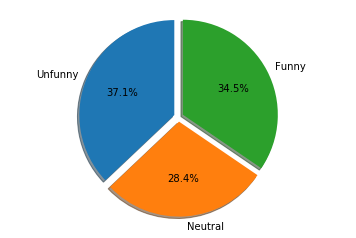

In [14]:
#pie chart
fig1, ax1 = plt.subplots()
ax1.pie([prop_unfunny, prop_neutral,prop_funny],
       labels=["Unfunny", "Neutral", "Funny"],
       shadow=True,
       explode=[0.05,0.05,0.05],
       autopct='%1.1f%%',
       startangle=90)
ax1.axis('equal')
plt.savefig("reports/figures/pie_labels.svg")

## 4 - Text Lengths 

In this section I will do some cleaning and analsyis on the text lengths,

In [15]:
#create text_length variable
df["text_length"] = df.text.str.len()

### 4.1 - Clean

There is no point in analyzing posts that are too short. These posts might be spam or links to jokes rather than actual jokes. Let us remove observations with very short text lengths. Specifically, we will drop posts with texts that are less than 3 characters. This will also remove texts with no text. The cutoff of three characters is kind of arbitrary, but seems safe. It is hard to imagine that there are many jokes with a punch line of only three characters.

In [16]:
n_obs_prev = df.shape[0]
df = df[df.text_length >= 4]
n_obs = df.shape[0]
print("{} observations droppped".format(n_obs_prev-n_obs))

5475 observations droppped


## 4.2 - Analyze

Let's see if there is relationship betwen score and lenght.

In [17]:
df.loc[df.type == "Unfunny", "text_length"].mean()

145.76378471650176

In [18]:
df.loc[df.type == "Neutral", "text_length"].mean()

180.81517448990968

In [19]:
df.loc[df.type == "Funny", "text_length"].mean()

296.31353256143882

It seem like funny posts are twice as long as unfuny posts on average.

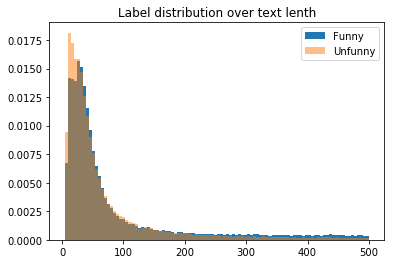

In [20]:
#now plot
plt.hist(df.loc[(df.type == "Funny") & (df.text_length <= 500), "text_length"], bins=100, normed=True, label='Funny')
plt.hist(df.loc[(df.type == "Unfunny") & (df.text_length <= 500), "text_length"], bins=100, normed=True, alpha=0.5, label='Unfunny')
plt.legend()
plt.title('Label distribution over text lenth')

From plot, it does not seem that length is huge facotr in wether or not a post is funny. However we will verify whether or not this is true.

# 5 - Final cleaning

In [21]:
#drop non informative
df = df[(df.ups >= 10) | (df.ups <= 1)]

In [22]:
df["funny"] = df.ups >= 10

In [23]:
df.shape

(224220, 11)

In [24]:
df["full_text"] = df.title + "\n " + df.text

In [25]:
df

,date,downs,score,text,title,ups,upvote_ratio,url,type,text_length,funny,full_text
id,,,,,,,,,,,,
6z8wju,1.505058e+09,0,1,"She cant make a Yo Mama Joke, oh wait, that’s ...",Yo Mama So Stupid.....,1,1.00,https://www.reddit.com/r/Jokes/comments/6z8wju...,Unfunny,63.0,False,Yo Mama So Stupid.....\n She cant make a Yo Ma...
6z8vwj,1.505058e+09,0,0,\nSnacks.,What do cannibals call midgets?,0,0.50,https://www.reddit.com/r/Jokes/comments/6z8vwj...,Unfunny,8.0,False,What do cannibals call midgets?\n \nSnacks.
6z8vgv,1.505058e+09,0,1,I only come once a year,My wife makes me feel like christmas,1,1.00,https://www.reddit.com/r/Jokes/comments/6z8vgv...,Unfunny,23.0,False,My wife makes me feel like christmas\n I only ...
6z8vea,1.505058e+09,0,1,Pennywise.,What do you call someone who gets their 1p cha...,1,1.00,https://www.reddit.com/r/Jokes/comments/6z8vea...,Unfunny,10.0,False,What do you call someone who gets their 1p cha...
6z8uq9,1.505058e+09,0,0,Woman's husband would always come home drunk. ...,You been drinking tonight?,0,0.50,https://www.reddit.com/r/Jokes/comments/6z8uq9...,Unfunny,1051.0,False,You been drinking tonight?\n Woman's husband w...
6z8ts1,1.505057e+09,0,0,So they can go fuck themselves,Priests in India are allowed to have sex,0,0.50,https://www.reddit.com/r/Jokes/comments/6z8ts1...,Unfunny,30.0,False,Priests in India are allowed to have sex\n So ...
6z8tpt,1.505057e+09,0,0,Because Trump will deport him. No illegal immi...,Why won't Hurricane Jose hit the USA?,0,0.33,https://www.reddit.com/r/Jokes/comments/6z8tpt...,Unfunny,87.0,False,Why won't Hurricane Jose hit the USA?\n Becaus...
6z8tnf,1.505057e+09,0,0,"Every time there is a powerful woman, there is...",The Thing About Irma and Jose,0,0.50,https://www.reddit.com/r/Jokes/comments/6z8tnf...,Unfunny,76.0,False,The Thing About Irma and Jose\n Every time the...
6z8t2q,1.505057e+09,0,1,Hot air baboon,What type of monkey can fly?,1,1.00,https://www.reddit.com/r/Jokes/comments/6z8t2q...,Unfunny,14.0,False,What type of monkey can fly?\n Hot air baboon


In [26]:
df = df.loc[:, ["funny", "full_text", "text_length"]]

In [27]:
#now split
train, test = train_test_split(df, test_size = 0.125, random_state = 123, stratify = df.funny)

In [28]:
#now save
joblib.dump(train,os.path.join(PROJECT_DIR,"data","interim","train.pkl"))
joblib.dump(test,os.path.join(PROJECT_DIR,"data","interim","test.pkl"))

['C:\\Users\\wertu\\Documents\\Datascience\\udacity-ml-capstone\\notebooks\\..\\data\\interim\\test.pkl']